# Import libraries

In [1]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import SimpleITK as sitk
import numpy as np

from utils import fig_3views, interpolation, interpolation_cupy

# Show annotation

In [2]:
df_anotation = pd.read_csv('/mnt/NAS/datasets/LuCAS-Plus/LungSegmentation/LUNA16/annotations.csv')
df_candidates = pd.read_csv('/mnt/NAS/datasets/LuCAS-Plus/LungSegmentation/LUNA16/candidates.csv')

In [3]:
df_candidates

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0
...,...,...,...,...,...
551060,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-55.66,37.24,-110.42,0
551061,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,68.40,70.18,-109.72,0
551062,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-82.29,-27.94,-106.92,0
551063,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,38.26,83.50,-102.71,0


### Analysis annotation

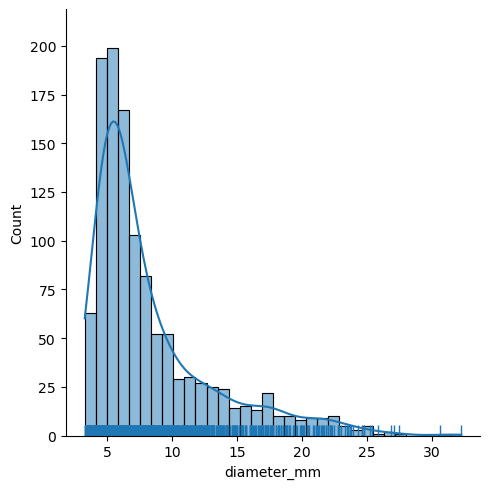

{'-5': 270, '5-10': 635, '10-': 281}


In [4]:
# plt.hist(df_anotation['diameter_mm'])
# plt.xlabel('count')
# plt.ylabel('diameter')
# plt.show()
# plt.close()

sns.displot(df_anotation['diameter_mm'], kde=True, rug=True)
plt.show()
plt.close()

dia_cnt_dict = {'-5':0, '5-10':0, '10-':0}
for i in range(len(df_anotation)):
    if df_anotation['diameter_mm'][i]<5:
        dia_cnt_dict['-5'] += 1
    elif df_anotation['diameter_mm'][i]<10:
        dia_cnt_dict['5-10'] += 1
    else:
        dia_cnt_dict['10-'] += 1
print(dia_cnt_dict)
    
    

### Analysis of candidates

In [5]:
class_dict = {0:0, 1:0}
for i in range(len(df_candidates)):
    class_dict[df_candidates['class'][i]] += 1
print(class_dict)
    

{0: 549714, 1: 1351}


# Show images

### reference pages
- mhd file manipulation:  https://github.com/tueimage/essential-skills/blob/master/medical-images.md#reading-3d-dicom-data
- luna16 preprocessing: https://www.kaggle.com/code/arnavkj95/candidate-generation-and-luna16-preprocessing

In [6]:
def normalize(npzarray, max_hu=400., min_hu=-1000.): 
    npzarray = (npzarray - min_hu) / (max_hu - min_hu)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

space [1.7999999523162842, 0.64453125, 0.64453125]
size (512, 512, 194)
(194, 512, 512)
coord [-298, -175, -128]
[140 136  29]
(48, 48, 48)
int16
3195


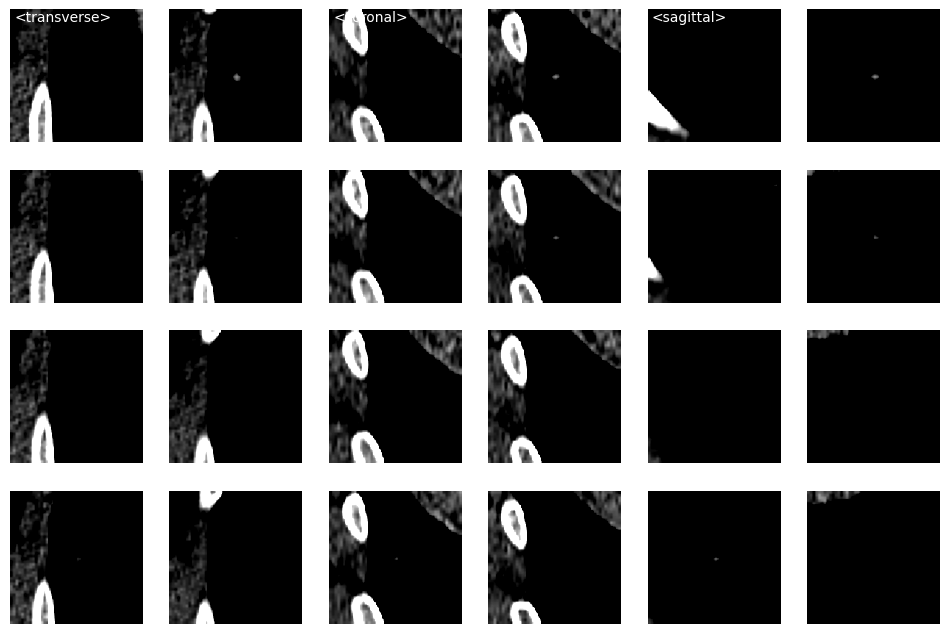

5.651470635
space [1.7999999523162842, 0.64453125, 0.64453125]
size (512, 512, 194)
(194, 512, 512)
coord [-227, -211, 103]
[211 100 260]
(48, 48, 48)
int16
3195


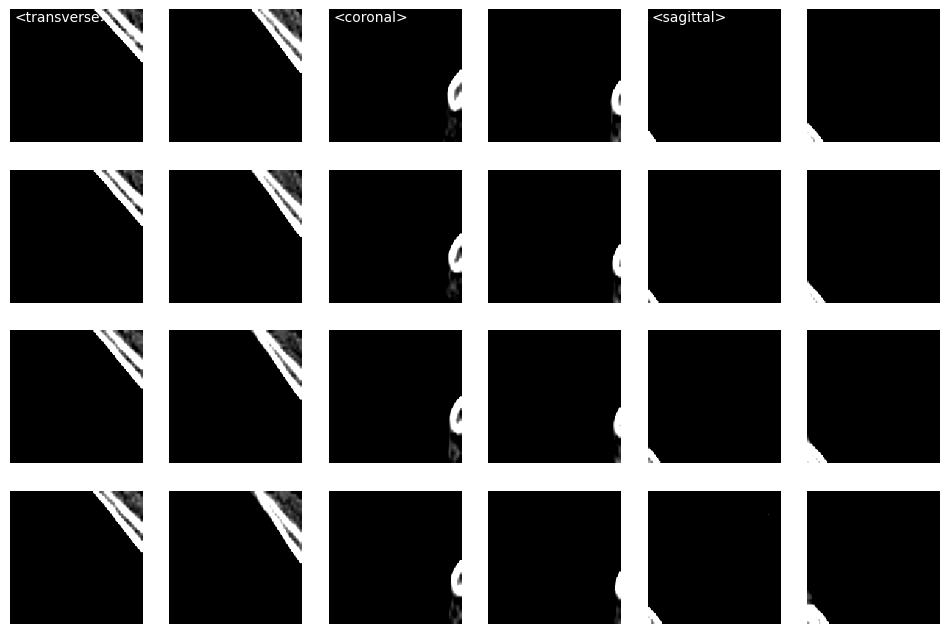

4.224708481


KeyboardInterrupt: Interrupted by user

In [8]:
dcm_dir = pathlib.Path('/mnt/NAS/datasets/LuCAS-Plus/LungSegmentation/LUNA16/all_series')
cs = 24
for i in range(len(df_anotation)):
    series_uid = df_anotation['seriesuid'][i]
    coords = [int(df_anotation['coordZ'][i]),int(df_anotation['coordY'][i]),int(df_anotation['coordX'][i])]
    diameter = df_anotation['diameter_mm'][i]
    mhd_path = dcm_dir / f"{series_uid}.mhd"
    ct_image = sitk.ReadImage(mhd_path)
    img_arr = sitk.GetArrayViewFromImage(ct_image)
    origin = list(reversed(ct_image.GetOrigin()))
    spacing = list(reversed(ct_image.GetSpacing()))
    img_arr = normalize(img_arr)
    
    print('space', spacing)
    print('size', ct_image.GetSize())
    print(img_arr.shape)
    print('coord', coords)
    
    new_spacing = [1.0, 1.0, 1.0]
    img_arr = interpolation_cupy(img_arr, spacing, new_spacing)
    
    voxel_coord = np.absolute(np.array(coords)-origin)
    voxel_coord /= np.array(new_spacing)
    
    voxel_coord = voxel_coord.astype(int)
    print(voxel_coord)
    pad_arr = np.pad(img_arr, ((cs,cs),(cs,cs),(cs,cs)), mode='constant', constant_values=0)
    
    
    patch = pad_arr[voxel_coord[0]:voxel_coord[0]+2*cs,
                     voxel_coord[1]:voxel_coord[1]+2*cs,
                     voxel_coord[2]:voxel_coord[2]+2*cs]
    print(patch.shape)
    print(patch.dtype)
    print(img_arr.max())
    fig, ax = fig_3views(patch, clim=(0,255))
    plt.show()
    plt.close()
    print(diameter)
    input('enter')

In [ ]:
'''
This function takes the numpy array of CT_Scan and a list of coords from
which voxels are to be cut. The list of voxel arrays are returned. We keep the 
voxels cubic because per pixel distance is same in all directions.
'''
def get_patch_from_list(lung_img, coords, window_size = 10):
	shape = lung_img.shape
	output = []
	lung_img = lung_img + 1024
	for i in range(len(coords)):
		patch =   lung_img[coords[i][0] - 18: coords[i][0] + 18,
						   coords[i][1] - 18: coords[i][1] + 18,
						   coords[i][2] - 18: coords[i][2] + 18]			   
		output.append(patch)
	
	return output

'''
Sample a random point from the image and return the coordinates. 
'''
def get_point(shape):
	x = randint(50, shape[2] - 50)
	y = randint(50, shape[1] - 50)
	z = randint(20, shape[0] - 20)
	return np.asarray([z, y, x])

'''
This function reads the training csv file which contains the CT Scan names and
location of each nodule. It cuts many voxels around a nodule and takes random points as 
negative samples. The voxels are dumped using pickle. It is to be noted that the voxels are 
cut from original Scans and not the masked CT Scans generated while creating candidate
regions.
'''
def create_data(path, train_csv_path):
	coords, trainY = [], []
	
	with open(train_csv_path, 'rb') as f:
		lines = f.readlines()
		
		for line in lines:
			row = line.split(',')
			
			if os.path.isfile(path + row[0] + '.mhd') == False:
				continue

			lung_img = sitk.GetArrayFromImage(sitk.ReadImage(path + row[0] + '.mhd'))

			for i in range(-5, 5, 3):
				for j in range(-5, 5, 3):
					for k in range(-2, 3, 2):
						coords.append([int(row[3]) + k, int(row[2]) + j, int(row[1]) + i])
						trainY.append(True)

			for i in range(60):			
				coords.append(get_point(lung_img.shape))
				trainY.append(False)

			trainX = get_patch_from_list(lung_img, coords)

			print (trainX[0].shape, len(trainX))

			pickle.dump(np.asarray(trainX), open('traindata_' + str(counter) + '_Xtrain.p', 'wb'))
			pickle.dump(np.asarray(trainY, dtype = bool),  open('traindata_' + str(counter) + '_Ytrain.p', 'wb'))

			counter = counter + 1
			coords, trainY = [], []